In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy import optimize
import statsmodels.api as sm
import math

# Problem 1

In [4]:
# set P(t-1)=100 and σ=0.1
Pt_1 = 100
sigma = 0.1
sample_size = 1_000_000
np.random.seed(222)
r = np.random.normal(0, sigma, sample_size)

In [5]:
# classical brownian
Pt = Pt_1 + r
print("expected value: ", Pt_1)
print("simulation result mean: ", round(Pt.mean(), 4))
print("expected standard deviation: ", sigma)
print("simulation result std deviation: ", round(Pt.std(), 4))

expected value:  100
simulation result mean:  100.0001
expected standard deviation:  0.1
simulation result std deviation:  0.1


In [6]:
# arithmetic return
Pt = Pt_1 * (1 + r)
print("expected value: ", Pt_1)
print("simulation result mean: ", round(Pt.mean(), 4))
print("expected standard deviation: ", sigma * Pt_1)
print("simulation result std deviation: ", round(Pt.std(), 4))

expected value:  100
simulation result mean:  100.009
expected standard deviation:  10.0
simulation result std deviation:  10.0006


In [7]:
# geometric brownian
Pt = Pt_1 * np.exp(r)
print("expected value: ", round(Pt_1 * math.exp(sigma * sigma / 2), 4))
print("simulation result mean: ", round(Pt.mean(), 4))
e_std_div = Pt_1 * math.sqrt((math.exp(sigma * sigma) - 1) * math.exp(sigma * sigma))
print("expected standard deviation: ", round(e_std_div, 4))
print("simulation result std deviation: ", round(Pt.std(), 4))

expected value:  100.5013
simulation result mean:  100.5104
expected standard deviation:  10.0753
simulation result std deviation:  10.078


# Problem 2

In [8]:
df = pd.read_csv("DailyPrices.csv")

In [9]:
def return_calculate(prices, method='DISCRETE', date_column='Date'):
    vars = prices.columns.drop(date_column)
    n_vars = prices.shape[1]
    if n_vars == vars.size:
        raise ValueError("date column: " + date_column + " not in DataFrame")
    n_vars -= 1

    p = prices[vars]
    out = (p / p.shift(1)).dropna()

    if method.upper() == "DISCRETE":
        out = out.apply(lambda x: x-1)
    elif method.upper() == "LOG":
        out = out.apply(np.log)
    else:
        raise ValueError("method: " + method + " must be 'LOG' or 'DISCRETE'")

    out.index = prices[date_column][1: ]
    return out

In [10]:
rets = return_calculate(df)

In [11]:
meta_ret = rets['META'].copy()
meta_ret -= meta_ret.mean() # μ=0
sigma = (np.array(meta_ret).var())**(1/2)
alpha = 0.05 # set α=5%

In [12]:
# normal distribution
VaR1 = -sps.norm.ppf(alpha, loc=0, scale=sigma)
print("under normal distribution, VaR = {:.2f}% loss".format(VaR1*100))

under normal distribution, VaR = 6.55% loss


In [13]:
sigma

0.03980243212896093

In [14]:
# normal distribution with exponentially weighted variance
def populate_weights(w, lamda):
    n = w.size
    for i in range(n):
        w[i] = (1 - lamda) * lamda ** (n - i - 1)
    for i in range(n):
        w[i] /= w.sum()
    w[-1] = 1. - w[: -1].sum() # solve float error, make weights sum to 1.0
    return w

In [15]:
weights = np.zeros(meta_ret.size)
populate_weights(weights, 0.94)
ew_var = (weights * meta_ret).T@meta_ret
VaR2 = -sps.norm.ppf(alpha, loc=0, scale=ew_var**(1/2))
print("under normal distribution with ew variance, VaR = {:.2f}% loss".format(VaR2*100))

under normal distribution with ew variance, VaR = 9.14% loss


In [16]:
ew_var**(1/2)

0.05555829155939741

In [17]:
# MLE fitted T distribution
def negative_t_ll(arguments):
    s, free = arguments[0], arguments[1]
    ll = sps.t.logpdf(meta_ret, free, loc=0.0, scale=s).sum()
    return -ll

In [18]:
bnds2 = ((0.000_000_01, None), (3, None))
guess = np.array([0.01, 6])
result = optimize.minimize(negative_t_ll, guess, bounds=bnds2)
t_sigma, d_free = result.x[0], result.x[1]
VaR3 = -sps.t.ppf(alpha, d_free, loc=0, scale=t_sigma)
print("under MLE fitted T distribution, VaR = {:.2f}% loss".format(VaR3*100))

under MLE fitted T distribution, VaR = 5.73% loss


In [19]:
d_free, t_sigma

(3.9225831323131994, 0.02670550191477702)

In [20]:
# fitted AR(1) model
meta_ret.index = pd.DatetimeIndex(meta_ret.index).to_period('D')
result = sm.tsa.AutoReg(meta_ret, lags=1).fit()
ret_t_1 = meta_ret[-1]
m = result.params[0]
beta = result.params[1]
er_scale = result.sigma2**(1/2)

sim_times = 1_000_000
sim_ret_t = beta * ret_t_1 + np.random.normal(0, er_scale, sim_times) + m
VaR4 = -np.percentile(sim_ret_t, alpha*100)
print("under AR(1) model, VaR = {:.2f}% loss".format(VaR4*100))

under AR(1) model, VaR = 6.58% loss


In [21]:
m, beta, er_scale

(-6.231553649016424e-05, 0.007232839275569024, 0.03987014452315942)

In [633]:
# historic simulation
sample_size = 1_000_000
np.random.seed(200)
sim_return = np.random.choice(meta_ret, sample_size)
VaR5 = -np.percentile(sim_return, alpha*100)
print("under historic simulation, VaR = {:.2f}% loss".format(VaR5*100))

under historic simulation, VaR = 5.59% loss


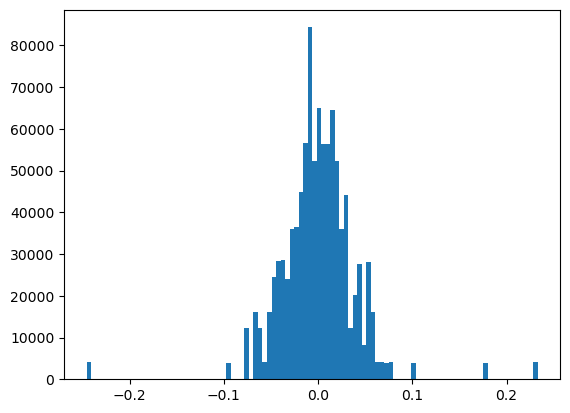

In [634]:
plt.hist(sim_return, bins=100);

# Problem 3

In [635]:
portfolio_df = pd.read_csv("portfolio.csv")

In [636]:
def conduct_pca(mat):
    eigenvalues, eigenvectors = np.linalg.eigh(mat)
    e_vals_sort = np.flip(np.real(eigenvalues), axis=0)
    pos_e_vals = e_vals_sort[e_vals_sort >= 1e-8]
    pos_e_vecs = np.flip(np.real(eigenvectors), axis=1)[:, : pos_e_vals.size]
    cum_explain = [pos_e_vals[:i+1].sum() / pos_e_vals.sum() for i in range(pos_e_vals.size)]
    return pos_e_vals, pos_e_vecs, cum_explain

def simulation_with_pca(mat, min_explain=1.0):
    pca = conduct_pca(mat)
    pca_vals = pca[0]
    pca_vecs = pca[1]
    for i, cum in enumerate(pca[2]):
        if cum >= min_explain:
            pca_vals = pca_vals[: i+1]
            pca_vecs = pca_vecs[:, : i+1]
    B = pca_vecs@np.diag(np.sqrt(pca_vals))
    r = np.random.standard_normal((B.shape[1], 25_000))
    X = (B@r).T
    return X

In [637]:
def populate_exp_weighted_cov_matrix(w, data):
    zero_mean = data.copy()
    for j in range(data.shape[1]):
        zero_mean.iloc[:, j] = data.iloc[:, j] - data.iloc[:, j].mean()
    result = zero_mean.multiply(w, axis=0).T@zero_mean
    return result

In [638]:
def calculate_portfolio_VaR(P, return_method='DISCRETE', model='M'):
    prices_P = df[['Date'] + list(P.keys())]
    holdings = np.array(list(P.values()))
    current_value_P = holdings.T@prices_P.iloc[-1, 1:]
    returns_P = return_calculate(prices_P, return_method)

    # simulate with exponentially weighted covariance
    weight = np.zeros(returns_P.shape[0])
    w = populate_weights(weight, 0.94)
    if model.upper() == 'M':
        ew_cov = populate_exp_weighted_cov_matrix(w, returns_P)
        sim_returns = simulation_with_pca(ew_cov) + np.array(returns_P.mean())
    elif model.upper() == 'H':
        row_draw = np.random.choice(returns_P.shape[0], 25_000, p=w)
        sim_returns = np.array(returns_P.iloc[row_draw, :])
    else:
        raise ValueError("model: " + model + "must be 'M' or 'H'")

    if return_method.upper() == 'DISCRETE':
        sim_prices = (sim_returns + 1) * np.array(prices_P.iloc[-1, 1:])
    elif return_method.upper() == 'LOG':
        sim_prices = np.exp(sim_returns) * np.array(prices_P.iloc[-1, 1:])
    else:
        raise ValueError("method: " + return_method + " must be 'LOG' or 'DISCRETE'")
    sim_value_P = (sim_prices * holdings).sum(axis=1)
    VaR_P = current_value_P - np.percentile(sim_value_P, alpha*100)
    return VaR_P

In [639]:
portfolio_A = portfolio_df[portfolio_df['Portfolio'] == 'A']
A = dict(zip(portfolio_A['Stock'], portfolio_A['Holding']))
VaR_A_dis = calculate_portfolio_VaR(A)
VaR_A_log = calculate_portfolio_VaR(A, return_method='log')
print("the VaR of portfolio A in dollar with discrete return: {:.2f}$ loss".format(VaR_A_dis))
print("the VaR of portfolio A in dollar with log return: {:.2f}$ loss".format(VaR_A_log))

the VaR of portfolio A in dollar with discrete return: 5620.37$ loss
the VaR of portfolio A in dollar with log return: 5539.85$ loss


In [640]:
portfolio_B = portfolio_df[portfolio_df['Portfolio'] == 'B']
B = dict(zip(portfolio_B['Stock'], portfolio_B['Holding']))
VaR_B_dis = calculate_portfolio_VaR(B)
VaR_B_log = calculate_portfolio_VaR(B, return_method='log')
print("the VaR of portfolio B in dollar with discrete return: {:.2f}$ loss".format(VaR_B_dis))
print("the VaR of portfolio B in dollar with log return: {:.2f}$ loss".format(VaR_B_log))

the VaR of portfolio B in dollar with discrete return: 4357.74$ loss
the VaR of portfolio B in dollar with log return: 4382.22$ loss


In [641]:
portfolio_C = portfolio_df[portfolio_df['Portfolio'] == 'C']
C = dict(zip(portfolio_C['Stock'], portfolio_C['Holding']))
VaR_C_dis = calculate_portfolio_VaR(C)
VaR_C_log = calculate_portfolio_VaR(C, return_method='log')
print("the VaR of portfolio C in dollar with discrete return: {:.2f}$ loss".format(VaR_C_dis))
print("the VaR of portfolio C in dollar with log return: {:.2f}$ loss".format(VaR_C_log))

the VaR of portfolio C in dollar with discrete return: 3753.22$ loss
the VaR of portfolio C in dollar with log return: 3736.56$ loss


In [642]:
total = {}
for k in (set(A) | set(B) | set(C)):
    total[k] = A.get(k, 0) + B.get(k, 0) + C.get(k, 0)
VaR_total_dis = calculate_portfolio_VaR(total)
VaR_total_log = calculate_portfolio_VaR(total, return_method='log')
print("the total VaR in dollar with discrete return: {:.2f}$ loss".format(VaR_total_dis))
print("the total VaR in dollar with log return: {:.2f}$ loss".format(VaR_total_log))

the total VaR in dollar with discrete return: 13470.81$ loss
the total VaR in dollar with log return: 13450.62$ loss


In [643]:
VaR_A_history = calculate_portfolio_VaR(A, 'discrete', 'h')
VaR_B_history = calculate_portfolio_VaR(B, 'discrete', 'h')
VaR_C_history = calculate_portfolio_VaR(C, 'discrete', 'h')
VaR_total_history = calculate_portfolio_VaR(total, 'discrete', 'h')
print("the VaR using history simulation: ")
print("A: {:.2f}$ loss".format(VaR_A_history))
print("B: {:.2f}$ loss".format(VaR_B_history))
print("C: {:.2f}$ loss".format(VaR_C_history))
print("total: {:.2f}$ loss".format(VaR_total_history))

the VaR using history simulation: 
A: 3452.11$ loss
B: 3631.77$ loss
C: 2754.59$ loss
total: 11064.37$ loss


In [644]:
VaR_A_history = calculate_portfolio_VaR(A, 'log', 'h')
VaR_B_history = calculate_portfolio_VaR(B, 'log', 'h')
VaR_C_history = calculate_portfolio_VaR(C, 'log', 'h')
VaR_total_history = calculate_portfolio_VaR(total, 'log', 'h')
print("the VaR using history simulation in log return: ")
print("A: {:.2f}$ loss".format(VaR_A_history))
print("B: {:.2f}$ loss".format(VaR_B_history))
print("C: {:.2f}$ loss".format(VaR_C_history))
print("total: {:.2f}$ loss".format(VaR_total_history))

the VaR using history simulation in log return: 
A: 4558.32$ loss
B: 3631.77$ loss
C: 2754.59$ loss
total: 11064.37$ loss
